In [1]:
run_gridsearch = True
skip_best_model_validation = False
skip_best_model_test = False
verbose = False
GPU_SETTING = -1
NUM_ENSEMBLES = 5
RUNS_FILE = "warm_springs_daily_stored_runs.json"
hyperparam_csv_file = "warm_springs_daily_hyperparams.csv"

In [2]:
hyperparam_space = {
    "hidden_size": [64, 128, 256],
    "seq_length": [90, 120],
    "num_layers": [1],
    "epochs": [16, 32, 48],
    "batch_size": [64, 128, 256],
    "schedule_pairs": [
        ((0.5, 0.25), (0.01, 0.005, 0.001))
    ]
}

In [3]:
import sys
import os
import itertools
import json
from pathlib import Path
from tqdm import tqdm
import warnings
from datetime import datetime
warnings.simplefilter(action='ignore', category=FutureWarning)

c:\Users\arman\Dropbox\The University\Projects\UCB-USACE-LSTMs\UCB_training\models\warm_springs_all


In [ ]:
current_dir = os.getcwd()
print(current_dir)

In [4]:
library_path = os.path.join('..', '..', '..','..','UCB-USACE-LSTMs')
sys.path.insert(0, library_path)
print(sys.path)

['..\\..\\..\\..\\UCB-USACE-LSTMs', 'c:\\Users\\arman\\anaconda3\\envs\\ucb-usace-project\\python313.zip', 'c:\\Users\\arman\\anaconda3\\envs\\ucb-usace-project\\DLLs', 'c:\\Users\\arman\\anaconda3\\envs\\ucb-usace-project\\Lib', 'c:\\Users\\arman\\anaconda3\\envs\\ucb-usace-project', '', 'c:\\Users\\arman\\anaconda3\\envs\\ucb-usace-project\\Lib\\site-packages', 'c:\\Users\\arman\\anaconda3\\envs\\ucb-usace-project\\Lib\\site-packages\\win32', 'c:\\Users\\arman\\anaconda3\\envs\\ucb-usace-project\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\arman\\anaconda3\\envs\\ucb-usace-project\\Lib\\site-packages\\Pythonwin']


In [5]:
from neuralhydrology.evaluation.metrics import *
from UCB_training.UCB_train import UCB_trainer
from UCB_training.UCB_utils import (combinedPlot, fancyCombinedPlot, combinedPlotFromDf, fancyCombinedPlotFromDf, fractional_multi_lr, write_paths, to_path_or_list, extended_combined_plot, extended_combined_plot_from_df)

In [6]:
current_path = os.getcwd()
library_path = current_path.split('UCB-USACE-LSTMs')[0] + 'UCB-USACE-LSTMs'

target_path = os.path.join(library_path, 'UCB_training', 'models', 'warm_springs_all')

if os.path.exists(target_path):
    os.chdir(target_path)
    print("Current Working Directory:", os.getcwd())
    print("Train Basin File Exists:", os.path.exists("warm_springs")) 
else:
    print(f"Error: The target path '{target_path}' does not exist.")

Current Working Directory: c:\Users\arman\Dropbox\The University\Projects\UCB-USACE-LSTMs\UCB_training\models\warm_springs_all
Train Basin File Exists: False


In [7]:
path_to_csv = Path(library_path +'/russian_river_data')
path_to_yaml = Path("warm_springs_dam_nlayer.yaml")
path_to_physics_data = Path(library_path + "/russian_river_data/WarmSprings_Inflow_daily_shift.csv")

In [8]:
features_with_physics = [
    #from daily.csv
    "DRY CREEK 20 PRECIP-INC SCREENED",
    "DRY CREEK 20 ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "DRY CREEK 30 PRECIP-INC SCREENED",
    "DRY CREEK 30 ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "UKIAH CA HUMIDITY USAF-NOAA",
    "UKIAH CA SOLAR RADIATION USAF-NOAA",
    "UKIAH CA TEMPERATURE USAF-NOAA",
    "UKIAH CA WINDSPEED USAF-NOAA",
    "SANTA ROSA CA HUMIDITY USAF-NOAA",
    "SANTA ROSA CA SOLAR RADIATION USAF-NOAA",
    "SANTA ROSA CA TEMPERATURE USAF-NOAA",
    "SANTA ROSA CA WINDSPEED USAF-NOAA",
    #from Warm_Spring_Inflow.csv
    'Dry Creek 20 ET-POTENTIAL',
    'Dry Creek 20 FLOW',
    'Dry Creek 20 FLOW-BASE',
    'Dry Creek 20 INFILTRATION',
    'Dry Creek 20 PERC-SOIL',
    'Dry Creek 20 SATURATION FRACTION',
    'Dry Creek 30 ET-POTENTIAL',
    'Dry Creek 30 FLOW',
    'Dry Creek 30 FLOW-BASE',
    'Dry Creek 30 INFILTRATION',
    'Dry Creek 30 PERC-SOIL',
    'Dry Creek 30 SATURATION FRACTION',
    'Warm Springs Dam Inflow FLOW',
]

In [9]:
no_physics_results = []
physics_results = []

In [10]:
start_time = datetime.utcnow()
print("Start time:", start_time.strftime("%Y-%m-%d %H:%M:%S"))

Start time: 2025-06-19 01:20:16


C:\Users\arman\AppData\Local\Temp\ipykernel_12420\901109023.py:2: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  start_time = datetime.utcnow()


In [11]:
hyperparam_names = []
for i, hp in enumerate(hyperparam_space.keys()):
    hyperparam_names.append(hp)

total_iters = 1
for name in hyperparam_names:
    total_iters *= len(hyperparam_space[name])

if run_gridsearch or not os.path.exists(hyperparam_csv_file):
    for combinations in tqdm(
        itertools.product(*[hyperparam_space[hp] for hp in hyperparam_names]), 
        desc="Grid-Search", 
        total=total_iters, 
        unit="it", 
        ncols=60, 
        ascii=True):

        hp_run = {}
        j = 0
        while j < len(hyperparam_names):
            if hyperparam_names[j] != "seq_length_1D" or hyperparam_names[j] != "seq_length_1H":
                hp_run[hyperparam_names[j]] = combinations[j]
                j += 1
            else:
                hp_run["seq_length"] = {"1D": combinations[j], "1H": combinations[j + 1]}
                j += 2

        if verbose:
            print(f"\nNoPhysics: {hp_run}")
        trainer = UCB_trainer(
            path_to_csv_folder=path_to_csv,
            yaml_path=path_to_yaml,
            hyperparams=hp_run,
            input_features=None,
            physics_informed=False,
            physics_data_file=None,
            hourly=False,  
            extend_train_period=False,
            gpu=GPU_SETTING,
            verbose=verbose,
        )
        trainer.train()
        csv_path, metrics_dict = trainer.results()
        
        row_data = {}
        j = 0
        while j < len(hyperparam_names):
            if hyperparam_names[j] == "learning_rate":
                row_data[hyperparam_names[j]] = str(combinations[j])
            else:
                row_data[hyperparam_names[j]] = combinations[j]
            j += 1
        for k, v in metrics_dict.items():
            row_data[k] = v
        
        no_physics_results.append(row_data)

    df_no_physics = pd.DataFrame(no_physics_results)
    df_no_physics.sort_values(by="NSE", ascending=False, inplace=True)
    df_no_physics.reset_index(drop=True, inplace=True)
else:
    print("Skipping grid search!")

Grid-Search: 100%|############| 2/2 [00:11<00:00,  5.61s/it]


In [12]:
if run_gridsearch or not os.path.exists(hyperparam_csv_file):    
    for combinations in tqdm(
        itertools.product(*[hyperparam_space[hp] for hp in hyperparam_names]), 
        desc="Grid-Search", 
        total=total_iters, 
        unit="it", ncols=60, 
        ascii=True):

        if "schedule_pairs" in hyperparam_names:
            (f1, f2), (lr1, lr2, lr3) = combinations[hyperparam_names.index("schedule_pairs")]

            fractions = [f1, f2]
            lr_list = [lr1, lr2, lr3]


            lr_dict = fractional_multi_lr(
                epochs=combinations[hyperparam_names.index("epochs")],
                fractions=fractions,
                lrs=lr_list,
                round_up=True)


        hp_run = {}
        j = 0
        while j < len(hyperparam_names):
            if hyperparam_names[j] != "seq_length_1D" or hyperparam_names[j] != "seq_length_1H":
                hp_run[hyperparam_names[j]] = combinations[j]
                j += 1
            else:
                hp_run["seq_length"] = {"1D": combinations[j], "1H": combinations[j + 1]}
                j += 2
        if verbose:
            print(f"\nPhysics: {hp_run}")
        trainer = UCB_trainer(
            path_to_csv_folder=path_to_csv,
            yaml_path=path_to_yaml,
            hyperparams=hp_run,
            input_features=features_with_physics,
            physics_informed=True,
            physics_data_file=path_to_physics_data,
            hourly=False,
            extend_train_period=False,
            gpu=GPU_SETTING,
            verbose=verbose,
        )
        trainer.train()
        csv_path, metrics_dict = trainer.results()

        row_data = {}
        j = 0
        while j < len(hyperparam_names):
            if hyperparam_names[j] == "learning_rate":
                row_data[hyperparam_names[j]] = str(combinations[j])
            else:
                row_data[hyperparam_names[j]] = combinations[j]
            j += 1

        for k, v in metrics_dict.items():
            row_data[k] = v
        physics_results.append(row_data)
    df_physics = pd.DataFrame(physics_results)
    df_physics.sort_values(by="NSE", ascending=False, inplace=True)
    df_physics.reset_index(drop=True, inplace=True)
    best_no_phys = df_no_physics.iloc[0].to_dict()
    best_phys = df_physics.iloc[0].to_dict()
    best_no_phys["model_type"] = "no_physics"
    best_phys["model_type"] = "physics"
    best_params_df = pd.DataFrame([best_no_phys, best_phys])
    best_params_df.to_csv(hyperparam_csv_file, index=False)
else:
    print("Skipping grid search!")

Grid-Search: 100%|############| 2/2 [00:06<00:00,  3.21s/it]


In [13]:
if run_gridsearch:
    print(df_no_physics.iloc[0:4])
    df_no_physics.to_csv("warm_springs_daily_no_physics_gridsearch.csv", index=False)

   hidden_size  seq_length  num_layers  epochs  batch_size  \
0           64         168           1       1          64   
1           32         168           1       1          64   

                        schedule_pairs       NSE            MSE        RMSE  \
0  ((0.5, 0.25), (0.01, 0.005, 0.001))  0.623587  184553.000000  429.596322   
1  ((0.5, 0.25), (0.01, 0.005, 0.001))  0.591514  200278.265625  447.524598   

        KGE  Alpha-NSE  Beta-KGE  Beta-NSE  Pearson-r        FHV        FMS  \
0  0.610733   0.669344  1.050559  0.023505   0.800904 -48.538410  69.034714   
1  0.503310   0.547212  0.912357 -0.040746   0.815602 -55.587841  -8.843243   

           FLV  Peak-Timing  Peak-MAPE  
0 -1084.637695          0.4  61.617680  
1 -2447.146484          0.2  67.664421  


In [14]:
if run_gridsearch:
    print(df_physics.iloc[0:4])
    df_physics.to_csv("warm_springs_daily_physics_gridsearch.csv", index=False)

   hidden_size  seq_length  num_layers  epochs  batch_size  \
0           64         168           1       1          64   
1           32         168           1       1          64   

                        schedule_pairs       NSE            MSE        RMSE  \
0  ((0.5, 0.25), (0.01, 0.005, 0.001))  0.726624  134034.609375  366.107374   
1  ((0.5, 0.25), (0.01, 0.005, 0.001))  0.700898  146647.750000  382.946145   

        KGE  Alpha-NSE  Beta-KGE  Beta-NSE  Pearson-r        FHV        FMS  \
0  0.690795   0.770343  0.847414 -0.070938   0.860061 -34.420956  10.370572   
1  0.719750   0.779528  0.934360 -0.030516   0.839927 -37.613297  64.472893   

           FLV  Peak-Timing  Peak-MAPE  
0 -1744.341675          0.0  39.341888  
1 -1240.580811          0.0  46.369217  


In [15]:
if os.path.exists(hyperparam_csv_file):
    best_params_df = pd.read_csv(hyperparam_csv_file)
    best_no_phys = best_params_df.query("model_type == 'no_physics'").iloc[0].to_dict()
    best_phys = best_params_df.query("model_type == 'physics'").iloc[0].to_dict()


    best_no_physics_params = {}
    j = 0
    while j < len(hyperparam_names):
        if hyperparam_names[j] == "output_dropout":
            best_no_physics_params[hyperparam_names[j]] = float(best_no_phys[hyperparam_names[j]])
            j += 1
        elif hyperparam_names[j] == "learning_rate":
            best_no_physics_params[hyperparam_names[j]] = eval(str(best_no_phys[hyperparam_names[j]]))
            j += 1
        elif hyperparam_names[j] == "seq_length_1D" or hyperparam_names[j] == "seq_length_1H":
            best_no_physics_params["seq_length"] = {"1D": int(best_no_phys[hyperparam_names[j]]), "1H": int(best_no_phys[hyperparam_names[j + 1]])}
            j += 2
        elif hyperparam_names[j] == "schedule_pairs":
            j += 1
            continue
        else:
            best_no_physics_params[hyperparam_names[j]] = int(best_no_phys[hyperparam_names[j]])
            j += 1
    
    best_physics_params = {}
    j = 0
    while j < len(hyperparam_names):
        if hyperparam_names[j] == "output_dropout":
            best_physics_params[hyperparam_names[j]] = float(best_phys[hyperparam_names[j]])
            j += 1
        elif hyperparam_names[j] == "learning_rate":
            best_physics_params[hyperparam_names[j]] = eval(str(best_phys[hyperparam_names[j]]))
            j += 1
        elif hyperparam_names[j] == "seq_length_1D" or hyperparam_names[j] == "seq_length_1H":
            best_physics_params["seq_length"] = {"1D": int(best_phys[hyperparam_names[j]]), "1H": int(best_phys[hyperparam_names[j + 1]])}
            j += 2
        elif hyperparam_names[j] == "schedule_pairs":
            j += 1
            continue
        else:
            best_physics_params[hyperparam_names[j]] = int(best_phys[hyperparam_names[j]])
            j += 1

    print("Loaded best hyperparams from CSV:")
    print("Best NO-PHYS:", best_no_physics_params)
    print("Best PHYS:", best_physics_params)
else:
    print(f"Error: {hyperparam_csv_file} not found. Did you run gridsearch?")

Loaded best hyperparams from CSV:
Best NO-PHYS: {'hidden_size': 64, 'seq_length': 168, 'num_layers': 1, 'epochs': 1, 'batch_size': 64}
Best PHYS: {'hidden_size': 64, 'seq_length': 168, 'num_layers': 1, 'epochs': 1, 'batch_size': 64}


### Re-run validation with best hyperparameters

In [16]:
if not skip_best_model_validation:
    lstmNoPhysicsValBest = UCB_trainer(
        path_to_csv_folder=path_to_csv,
        yaml_path=path_to_yaml,
        hyperparams=best_no_physics_params,
        input_features=None,
        physics_informed=False,
        physics_data_file=None,
        hourly=False,
        extend_train_period=False,
        gpu=GPU_SETTING,
        # num_ensemble_members = NUM_ENSEMBLES,
        verbose=verbose,
    )
    lstmNoPhysicsValBest.train()
    no_physics_val_csv, no_physics_val_metrics = lstmNoPhysicsValBest.results()
    no_physics_val_metrics

In [17]:
if not skip_best_model_validation:
    lstmPhysicsValBest = UCB_trainer(
        path_to_csv_folder=path_to_csv,
        yaml_path=path_to_yaml,
        hyperparams=best_physics_params,
        input_features=features_with_physics,
        physics_informed=True,
        physics_data_file=path_to_physics_data,
        hourly=False,
        extend_train_period=False,
        gpu=GPU_SETTING,
        # num_ensemble_members = NUM_ENSEMBLES,
        verbose=verbose
    )
    lstmPhysicsValBest.train()
    physics_val_csv, physics_val_metrics = lstmPhysicsValBest.results()
    physics_val_metrics

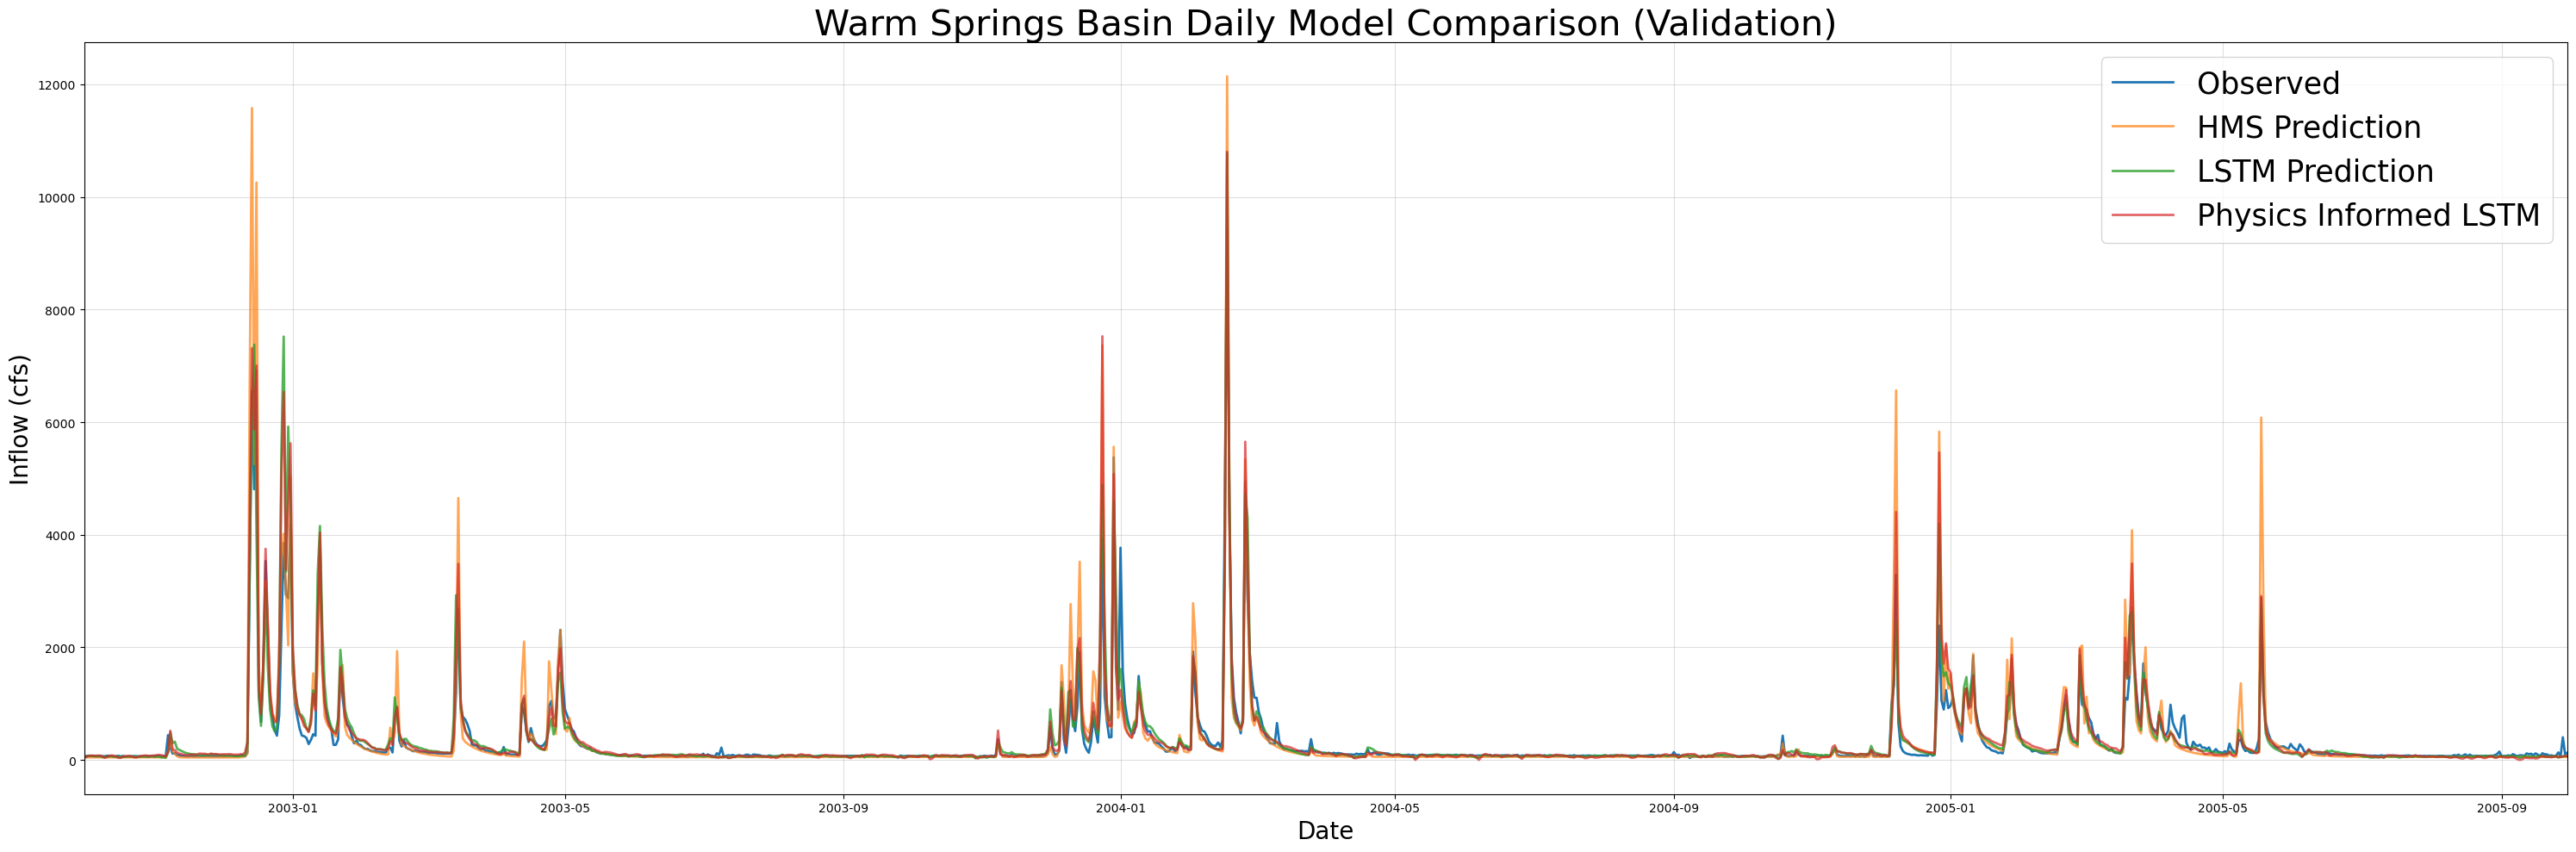

In [18]:
if not skip_best_model_validation:
    combinedPlot(
        lstm_results=no_physics_val_csv,
        lstmPhysics_results=physics_val_csv,
        HMS_results=path_to_physics_data,
        title="Warm Springs Basin Daily Model Comparison (Validation)",
        fName="warm_springs_daily_val_metrics.csv",
        plot_filename="warm_springs_daily_val_model_comparison.png",
        timeseries_filename ="warm_springs_daily_val_combined_ts.csv"
    )
else:
    combined_df = pd.read_csv("warm_springs_daily_val_combined_ts.csv")
    combinedPlotFromDf(combined_df, title="Warm Springs Basin Daily Model Comparison (Validation)", fName="warm_springs_daily_val_metrics.csv")

In [19]:
if not skip_best_model_validation:
    fancyCombinedPlot(
        lstm_results=no_physics_val_csv,
        lstmPhysics_results=physics_val_csv,
        HMS_results=path_to_physics_data,
        title='Warm Springs Basin Daily Model Comparison (Validation)',
        fName="warm_springs_daily_val_metrics.csv",
        timeseries_filename ="warm_springs_daily_val_combined_ts.csv"
    )
else:
    fancyCombinedPlotFromDf(combined_df, title='Warm Springs Basin Daily Model Comparison (Validation)',
                             fName="warm_springs_daily_val_metrics.csv")

In [20]:
if skip_best_model_validation:
    val_metrics = pd.read_csv("warm_springs_daily_val_metrics.csv", index_col=0)
    print(val_metrics)

                       HMS          LSTM  Physics_Informed_LSTM
NSE               0.695953      0.832832               0.854659
MSE          149072.347123  81961.443220           71259.597336
RMSE            386.098883    286.289090             266.944933
KGE               0.629025      0.833929               0.777180
Alpha-NSE         1.354620      1.128169               1.190491
Beta-KGE          1.087268      1.082311               1.106571
Beta-NSE          0.040572      0.038267               0.049546
Pearson-r         0.934799      0.933841               0.955229
FHV              34.412169     13.542671              22.334035
FMS              11.222054      4.019818               3.611877
FLV              75.843904   -135.852858           -2733.440710
Peak-Timing       0.000000      0.200000               0.000000
Peak-MAPE        57.593945     23.895835              13.002124
PBIAS            -8.726809     -8.231130             -10.657133


### Re-run testing with best hyperparameters

[UCB Trainer] Using CPU (unhandled gpu=-1).
2025-06-18 18:20:37,722: Logging to c:\Users\arman\Dropbox\The University\Projects\UCB-USACE-LSTMs\UCB_training\models\warm_springs_all\runs\testing_run_1806_182037\output.log initialized.
2025-06-18 18:20:37,723: ### Folder structure created at c:\Users\arman\Dropbox\The University\Projects\UCB-USACE-LSTMs\UCB_training\models\warm_springs_all\runs\testing_run_1806_182037
2025-06-18 18:20:37,724: ### Run configurations for testing_run
2025-06-18 18:20:37,725: experiment_name: testing_run
2025-06-18 18:20:37,726: train_basin_file: warm springs
2025-06-18 18:20:37,727: validation_basin_file: warm springs
2025-06-18 18:20:37,728: test_basin_file: warm springs
2025-06-18 18:20:37,730: train_start_date: 1994-10-01 00:00:00
2025-06-18 18:20:37,732: train_end_date: 2005-09-30 00:00:00
2025-06-18 18:20:37,733: validation_start_date: 2002-10-01 00:00:00
2025-06-18 18:20:37,734: validation_end_date: 2005-09-30 00:00:00
2025-06-18 18:20:37,735: test_sta

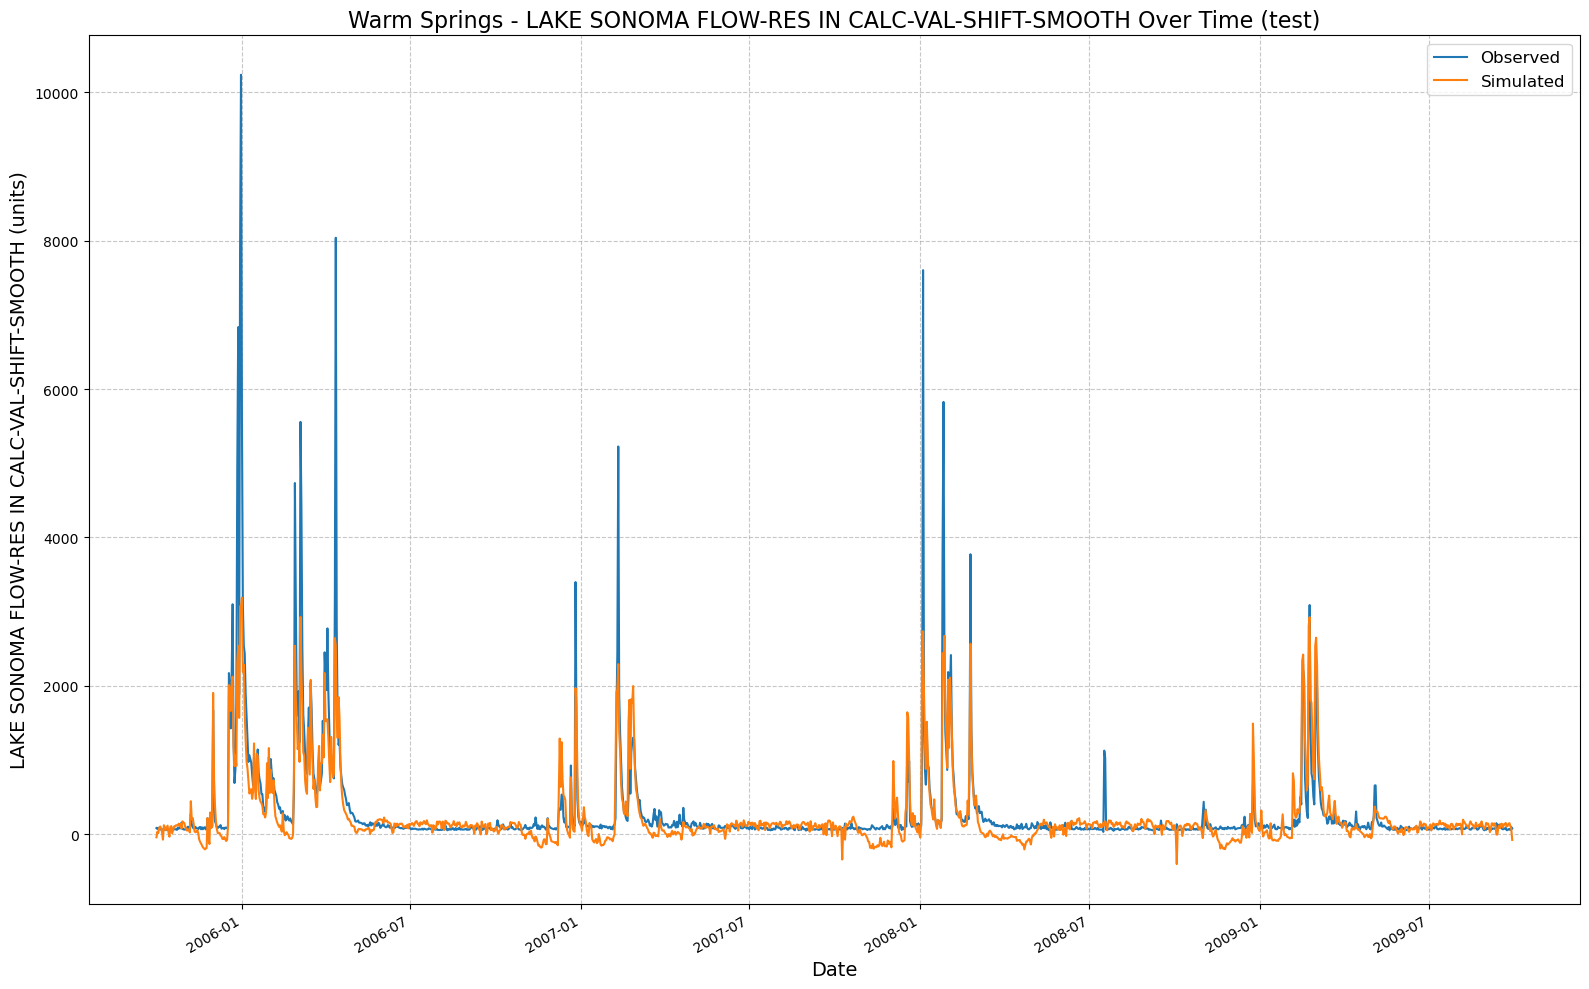

In [21]:
if not skip_best_model_test:
    lstmNoPhysicsExtBest = UCB_trainer(
        path_to_csv_folder=path_to_csv,
        yaml_path=path_to_yaml,
        hyperparams=best_no_physics_params,
        input_features=None,
        physics_informed=False,
        physics_data_file=None,
        hourly=False,
        extend_train_period=True,  
        gpu=GPU_SETTING,
        num_ensemble_members = NUM_ENSEMBLES,
        verbose=verbose
    )
    
    lstmNoPhysicsExtBest.train()
    no_physics_test_csv, no_physics_test_metrics = lstmNoPhysicsExtBest.results('test')
    no_physics_test_metrics

[UCB Trainer] Using CPU (unhandled gpu=-1).
2025-06-18 18:20:42,799: Logging to c:\Users\arman\Dropbox\The University\Projects\UCB-USACE-LSTMs\UCB_training\models\warm_springs_all\runs\testing_run_1806_182042\output.log initialized.
2025-06-18 18:20:42,801: ### Folder structure created at c:\Users\arman\Dropbox\The University\Projects\UCB-USACE-LSTMs\UCB_training\models\warm_springs_all\runs\testing_run_1806_182042
2025-06-18 18:20:42,802: ### Run configurations for testing_run
2025-06-18 18:20:42,803: experiment_name: testing_run
2025-06-18 18:20:42,804: train_basin_file: warm springs
2025-06-18 18:20:42,805: validation_basin_file: warm springs
2025-06-18 18:20:42,806: test_basin_file: warm springs
2025-06-18 18:20:42,806: train_start_date: 1994-10-01 00:00:00
2025-06-18 18:20:42,807: train_end_date: 2005-09-30 00:00:00
2025-06-18 18:20:42,807: validation_start_date: 2002-10-01 00:00:00
2025-06-18 18:20:42,808: validation_end_date: 2005-09-30 00:00:00
2025-06-18 18:20:42,809: test_sta

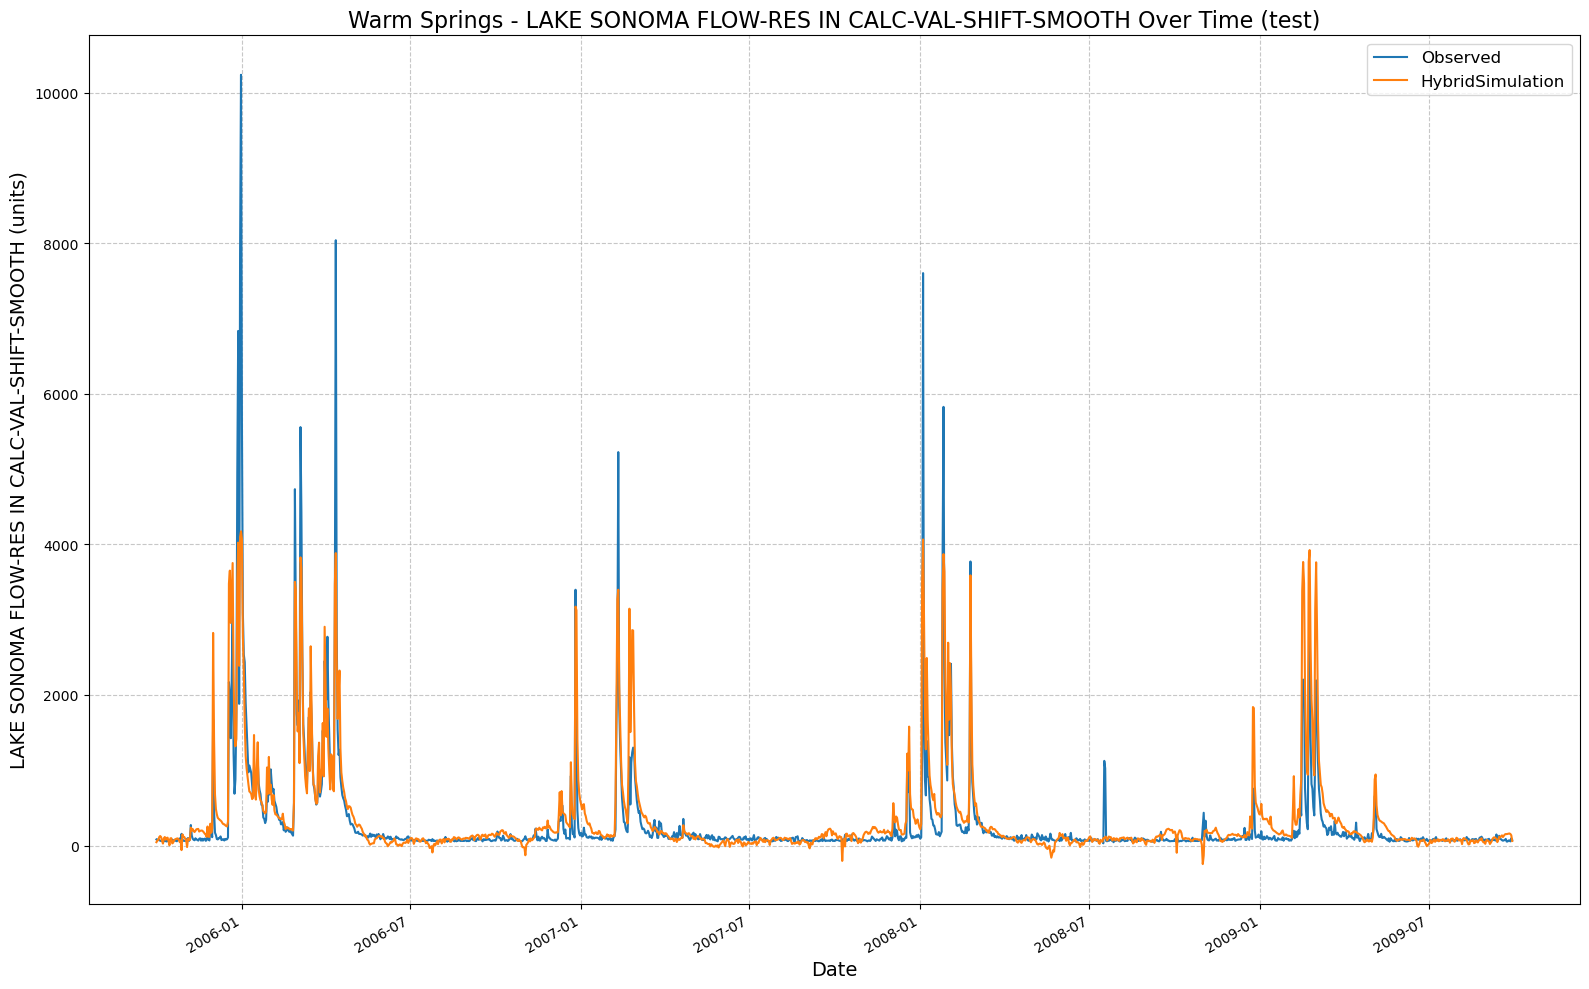

In [22]:
if not skip_best_model_test:
    lstmPhysicsExtBest = UCB_trainer(
        path_to_csv_folder=path_to_csv,
        yaml_path=path_to_yaml,
        hyperparams=best_physics_params,
        input_features=features_with_physics,
        physics_informed=True,
        physics_data_file=path_to_physics_data,
        hourly=False,
        extend_train_period=True,
        gpu=GPU_SETTING,
        # num_ensemble_members = NUM_ENSEMBLES,
        verbose=verbose
    )
    
    lstmPhysicsExtBest.train()
    physics_test_csv, physics_test_metrics = lstmPhysicsExtBest.results('test')
    physics_test_metrics

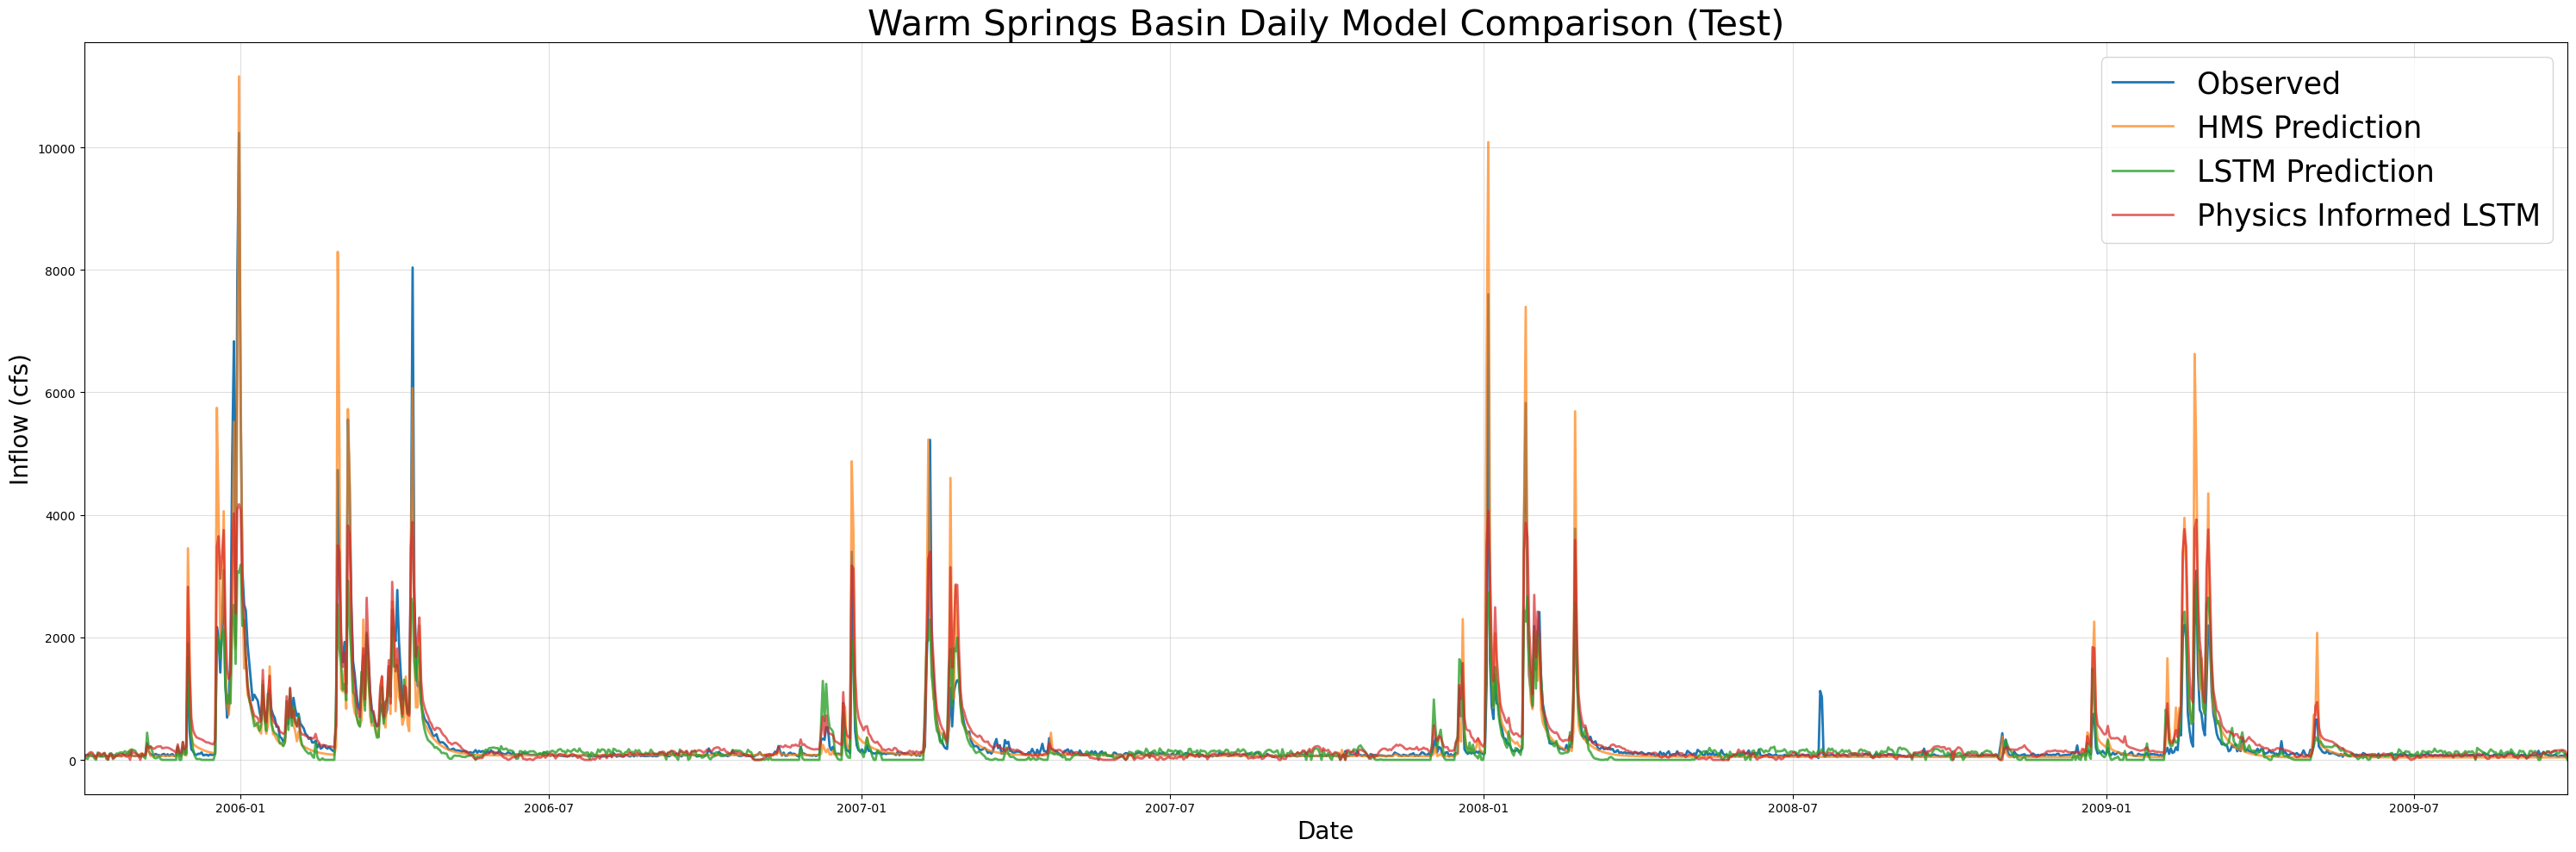

In [23]:
if not skip_best_model_test:
    combinedPlot(
        lstm_results=no_physics_test_csv,
        lstmPhysics_results=physics_test_csv,
        HMS_results=path_to_physics_data,
        title="Warm Springs Basin Daily Model Comparison (Test)",
        fName="warm_springs_daily_test_metrics.csv",
        plot_filename="warm_springs_daily_test_model_comparison.png",
        timeseries_filename ="warm_springs_daily_test_combined_ts.csv"
    )
else:
    combined_df = pd.read_csv("warm_springs_daily_test_combined_ts.csv")
    combinedPlotFromDf(combined_df, title="Warm Springs Basin Daily Model Comparison (Test)", fName="warm_springs_daily_test_metrics.csv")

In [24]:
if not skip_best_model_test:
    fancyCombinedPlot(lstm_results=no_physics_test_csv, lstmPhysics_results= physics_test_csv, HMS_results=path_to_physics_data, title='Warm Springs Basin Daily Model Comparison', fName = "warm_springs_daily_test_metrics.csv", timeseries_filename ="warm_springs_daily_test_combined_ts.csv")
else:
    fancyCombinedPlotFromDf(combined_df, title='Warm Springs Basin Daily Model Comparison', fName = "warm_springs_daily_test_metrics.csv")

In [25]:
# if skip_best_model_train:
test_metrics = pd.read_csv("warm_springs_daily_test_metrics.csv", index_col=0)
print(test_metrics)

                       HMS           LSTM  Physics_Informed_LSTM
NSE               0.732375       0.683109               0.739198
MSE          143312.877184  169694.790880          139659.194314
RMSE            378.566873     411.940276             373.710040
KGE               0.791169       0.594995               0.741503
Alpha-NSE         1.179486       0.653432               0.904162
Beta-KGE          1.038166       0.851404               1.198145
Beta-NSE          0.015523      -0.060437               0.080590
Pearson-r         0.900309       0.852220               0.864448
FHV              24.454837     -41.961068             -15.414384
FMS              25.219424      33.391021              51.566487
FLV              79.322057    -659.126073           -1963.918113
Peak-Timing       0.833333       0.500000               0.333333
Peak-MAPE        44.995233      58.935297              51.841526
PBIAS            -3.816588      14.859554             -19.814500


In [26]:
end_time = datetime.utcnow()
print("\nEnd time:", end_time.strftime("%Y-%m-%d %H:%M:%S"))
print("Total time:", end_time - start_time)


End time: 2025-06-19 01:20:54
Total time: 0:00:37.205612


C:\Users\arman\AppData\Local\Temp\ipykernel_12420\3925244319.py:1: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



In [ ]:
if not skip_best_model_test:
    write_paths("no_physics", lstmNoPhysicsExtBest, filename = RUNS_FILE)
    write_paths("physics", lstmPhysicsExtBest, filename = RUNS_FILE)
saved = json.loads(Path(RUNS_FILE).read_text())

##### Reload Models for Prediction

In [ ]:
runner_np = UCB_trainer.from_run_dir(to_path_or_list(saved["no_physics"]), gpu=GPU_SETTING, verbose=verbose)
runner_ph = UCB_trainer.from_run_dir(to_path_or_list(saved["physics"]), gpu=GPU_SETTING, verbose=verbose)

In [ ]:
pred_np_d_train_validation, obs_np_d_train_validation, met_np_d_train_validation = runner_np.predict(period="train_validation")
met_np_d_train_validation.to_dict()

In [ ]:
pred_np_d_test, obs_np_d_test, met_np_d_test = runner_np.predict(period="test")
met_np_d_test.to_dict()

In [ ]:
pred_ph_d_train_validation, obs_ph_d_train_validation, met_ph_d_train_validation = runner_ph.predict(period="train_validation")
met_ph_d_train_validation.to_dict()

In [ ]:
pred_ph_d_test, obs_ph_d_test, met_ph_d_test = runner_ph.predict(period="test")
met_ph_d_test.to_dict()

##### Additional Plots

In [ ]:
wettest_start = "2005-10-01"
wettest_end = "2006-09-30"
dryest_start = "2008-10-01"
dryest_end = "2009-09-30"
metric_list = ["NSE", "PBIAS"]

##### Wettest Year Performance

In [ ]:
if not skip_best_model_test:
    extended_combined_plot(
        lstm_results=no_physics_test_csv,
        lstmPhysics_results=physics_test_csv,
        HMS_results=path_to_physics_data,
        title="Warm Springs Daily Wettest Year Timeseries",
        start_date=wettest_start,
        end_date=wettest_end,
        metrics=metric_list,
        fName="warm_springs_daily_wet_metrics.csv",
        timeseries_filename="warm_springs_daily_wet_ts.csv",
        plot_filename="warm_springs_daily_wet_plot.png")
else:
    extended_combined_plot_from_df(
        df=combined_df,
        title="Warm Springs Daily Wettest Year Timeseries",
        start_date=wettest_start,
        end_date=wettest_end,
        metrics=metric_list,
        fName="warm_springs_daily_wet_metrics.csv",
        timeseries_filename="warm_springs_daily_wet_ts.csv",
        plot_filename="warm_springs_daily_wet_plot.png")

In [ ]:
if not skip_best_model_test:
    extended_combined_plot(
        lstm_results=no_physics_test_csv,
        lstmPhysics_results=physics_test_csv,
        HMS_results=path_to_physics_data,
        title="Warm Springs Daily Wettest Year Timeseries - Interactive",
        start_date=wettest_start,
        end_date=wettest_end,
        metrics=metric_list,
        fName="warm_springs_daily_wet_metrics.csv",
        timeseries_filename="warm_springs_daily_wet_ts.csv",
        plot_filename="warm_springs_daily_wet_plot.png",
        interactive=True)
else:
    extended_combined_plot_from_df(
        df=combined_df,
        title="Warm Springs Daily Wettest Year Timeseries - Interactive",
        start_date=wettest_start,
        end_date=wettest_end,
        metrics=metric_list,
        fName="warm_springs_daily_wet_metrics.csv",
        timeseries_filename="warm_springs_daily_wet_ts.csv",
        plot_filename="warm_springs_daily_wet_plot.png",
        interactive=True)

##### Dryest Year Performance

In [ ]:
if not skip_best_model_test:
    extended_combined_plot(
        lstm_results=no_physics_test_csv,
        lstmPhysics_results=physics_test_csv,
        HMS_results=path_to_physics_data,
        title="Warm Springs Daily Dryest Year Timeseries",
        start_date=dryest_start,
        end_date=dryest_end,
        metrics=metric_list,
        fName="warm_springs_daily_dry_metrics.csv",
        timeseries_filename="warm_springs_daily_dry_ts.csv",
        plot_filename="warm_springs_daily_dry_plot.png")
else:
    extended_combined_plot_from_df(
        df=combined_df,
        title="Warm Springs Daily Dryest Year Timeseries",
        start_date=dryest_start,
        end_date=dryest_end,
        metrics=metric_list,
        fName="warm_springs_daily_dry_metrics.csv",
        timeseries_filename="warm_springs_daily_dry_ts.csv",
        plot_filename="warm_springs_daily_dry_plot.png")

In [ ]:
if not skip_best_model_test:
    extended_combined_plot(
        lstm_results=no_physics_test_csv,
        lstmPhysics_results=physics_test_csv,
        HMS_results=path_to_physics_data,
        title="Warm Springs Daily Dryest Year Timeseries - Interactive",
        start_date=dryest_start,
        end_date=dryest_end,
        metrics=metric_list,
        fName="warm_springs_daily_dry_metrics.csv",
        timeseries_filename="warm_springs_daily_dry_ts.csv",
        plot_filename="warm_springs_daily_dry_plot.png",
        interactive=True)
else:
    extended_combined_plot_from_df(
        df=combined_df,
        title="Warm Springs Daily Dryest Year Timeseries - Interactive",
        start_date=dryest_start,
        end_date=dryest_end,
        metrics=metric_list,
        fName="warm_springs_daily_dry_metrics.csv",
        timeseries_filename="warm_springs_daily_dry_ts.csv",
        plot_filename="warm_springs_daily_dry_plot.png",
        interactive=True)